In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

### This template is for
- objFuncs: v1.0.4  
- pyBO: v1.0.2

In [4]:
import objFuncs
from objFuncs import VM, objFuncGoals, construct_machineIO
from objFuncs.preset import get_preset, get_tolerance, get_limits
from pyBO import pyBO

objFuncs version: 1.0.4. updated on 2024-03-26


/home/devuser/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


pyBO version: 1.0.2. updated on 2024-03-26


In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from phantasy import caget,fetch_data
import pandas as pd

# user inputs
### check and adjust decision (control knobs) and objectives later

In [6]:
is_close_to_opt = False     # True for local optimization. 
FC814 = 30                  # uA
timespan_for_average = 2.0  # sec  
additional_wait_after_powersupply_ramp  = 0.25 # sec

In [7]:
if is_close_to_opt:
    n_init_budget       = 4   # recommended: number of decision parameters 
    n_global_opt_budget = 0
    n_local_opt_budget  = 8
    n_finetune_budget   = 2   # recommended: less than number of decision parameters 
else:
    n_init_budget       = 8          
    n_global_opt_budget = 8
    n_local_opt_budget  = 8
    n_finetune_budget   = 2    # recommended: less than number of decision parameters 

budget = n_init_budget +n_global_opt_budget +n_local_opt_budget +n_finetune_budget
print(f"budget: {budget}")

budget: 26


# check machineIO, source and beam  

In [8]:
objFuncs._global_machineIO._test = True
objFuncs._global_machineIO._fetch_data_time_span = timespan_for_average
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = additional_wait_after_powersupply_ramp

In [9]:
SCS = 1
ion = 'Ca'
Q = 10
A = 16
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS1 16Ca10 A/Q= 1.6


In [10]:
now0 = datetime.datetime.now()
fname = now0.strftime('%Y%m%d_%H%M')+'['+ion+'][pyBO][MEBT]FC1108'
fname

'20240327_1539[16Ca10][pyBO][MEBT]FC1108'

# preprare decision ( control knob)

In [11]:
# preset = get_preset('[MEBT]FC1102',offline=True)
# preset

In [12]:
decision_CSETs = [
                 'FE_LEBT:PSC2_D0964:I_CSET', 'FE_LEBT:PSC1_D0964:I_CSET',
#                  'FE_LEBT:PSC2_D0979:I_CSET', 'FE_LEBT:PSC1_D0979:I_CSET',
#                  'FE_LEBT:PSC2_D0992:I_CSET', 'FE_LEBT:PSC1_D0992:I_CSET',
                  ]
decision_min   = [ -5]*len(decision_CSETs)
decision_max   = [  5]*len(decision_CSETs)
decision_tols  = [0.2]*len(decision_CSETs)

pd.DataFrame(np.array([decision_min,decision_max,decision_tols]).T,
             index=decision_CSETs, 
             columns=['decision min','decision max','tol'])

,decision min,decision max,tol
FE_LEBT:PSC2_D0964:I_CSET,-5.0,5.0,0.2
FE_LEBT:PSC1_D0964:I_CSET,-5.0,5.0,0.2


# preprare objective function

In [13]:
objective_goal= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : -0.345812289535008,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 0.2755291980547795,
    'FE_MEBT:BPM_D1056:PHASE_RD': 80.01379620843083,
    'FE_MEBT:BPM_D1072:XPOS_RD' : 0.11800521457630664,
    'FE_MEBT:BPM_D1072:YPOS_RD' : 0.4313544346071099,
    'FE_MEBT:BPM_D1072:PHASE_RD': -23.42850231099402,
    'FE_MEBT:BPM_D1094:XPOS_RD' : 0.04434067124873937,
    'FE_MEBT:BPM_D1094:YPOS_RD' : -0.15548171891011758,
    'FE_MEBT:BPM_D1094:PHASE_RD': -14.992799801690156,
    'FE_MEBT:BCM_D1055:AVGPK_RD': {'more than': FC814},
    'FE_MEBT:FC_D1102:PKAVG_RD' : {'more than': 0.8*FC814},
}

In [14]:
objective_norm= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 1,
    'FE_MEBT:BPM_D1056:PHASE_RD': 1,
    'FE_MEBT:BPM_D1072:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1072:YPOS_RD' : 1,
    'FE_MEBT:BPM_D1072:PHASE_RD': 1,
    'FE_MEBT:BPM_D1094:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1094:YPOS_RD' : 1,
    'FE_MEBT:BPM_D1094:PHASE_RD': 1,
    'FE_MEBT:BCM_D1055:AVGPK_RD': 0.05*FC814,
    'FE_MEBT:FC_D1102:PKAVG_RD' : 0.05*0.8*FC814,
}

In [15]:
# set weight to zero if you don't want to include the corresponding objective

objective_weight= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : 0.8,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 0.8,
    'FE_MEBT:BPM_D1056:PHASE_RD': 0,  #1,
    'FE_MEBT:BPM_D1072:XPOS_RD' : 0,  #0.4,
    'FE_MEBT:BPM_D1072:YPOS_RD' : 0,  #0.4,
    'FE_MEBT:BPM_D1072:PHASE_RD': 0,  #0.5,
    'FE_MEBT:BPM_D1094:XPOS_RD' : 0,  #0.2,
    'FE_MEBT:BPM_D1094:YPOS_RD' : 0,  #0.2,
    'FE_MEBT:BPM_D1094:PHASE_RD': 0,  #0.25,
    'FE_MEBT:BCM_D1055:AVGPK_RD': 2,
    'FE_MEBT:FC_D1102:PKAVG_RD' : 2,
}

# construct VM

In [16]:
machineIO = construct_machineIO()
machineIO._test = True

In [17]:
vm = VM(
    x0 = np.zeros(len(decision_CSETs)),
    decision_CSETs = decision_CSETs,
    decision_min   = decision_min,
    decision_max   = decision_max,
    objective_RDs  = list(objective_goal.keys()),
    objective_RDs_mean = [list(val.values())[0] if isinstance(val, dict) else val 
                          for val in objective_goal.values()],
    objective_RDs_std  = [val for val in objective_norm.values()],
    real_time_delay = 0.2,
)

In [18]:
machineIO._ensure_set = vm.ensure_set
machineIO._fetch_data = vm.fetch_data
machineIO._caget      = vm.caget
machineIO._caput      = vm.caput

In [19]:
obj = objFuncGoals(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    apply_bilog = True,
    machineIO=machineIO,
)

======== class info ========
init_time: 2024-03-27 15:39:15.893875
class_hierarchy: [
    objFuncGoals, objFuncBase]
machineIO: not picklable
decision_CSETs: [
    FE_LEBT:PSC2_D0964:I_CSET, FE_LEBT:PSC1_D0964:I_CSET]
decision_min: [-5. -5.]
decision_max: [5. 5.]
decision_bounds: [[-5  5]
 [-5  5]]
decision_RDs: [
    FE_LEBT:PSC2_D0964:I_RD, FE_LEBT:PSC1_D0964:I_RD]
decision_tols: [0.2 0.2]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [0. 0.]
plot_time_val: <class 'objFuncs.util.plot_time_val'>
plot_obj_history: <class 'objFuncs.util.plot_obj_history'>
objective_weight:
    FE_MEBT:BPM_D1056:XPOS_RD: 0.14285714285714288
    FE_MEBT:BPM_D1056:YPOS_RD: 0.14285714285714288
    FE_MEBT:BCM_D1055:AVGPK_RD: 0.35714285714285715
    FE_MEBT:FC_D1102:PKAVG_RD: 0.35714285714285715
objective_goal:
    FE_MEBT:BPM_D1056:XPOS_RD: -0.345812289535008
    FE_MEBT:BPM_D1056:YPOS_RD: 0.2755291980547795
    FE_MEBT:BCM_D1055:AVGPK_RD: {'

# run Optim

In [20]:
ctrBO = pyBO.bo_controller(obj,local_optimization = is_close_to_opt)

init will random sample within the following bounds:


,min,max
FE_LEBT:PSC2_D0964:I_CSET,-5,5
FE_LEBT:PSC1_D0964:I_CSET,-5,5


scipy version mismatch. 'scipy.stat.qmc' is not imported. Using custom halton seqeunce instead


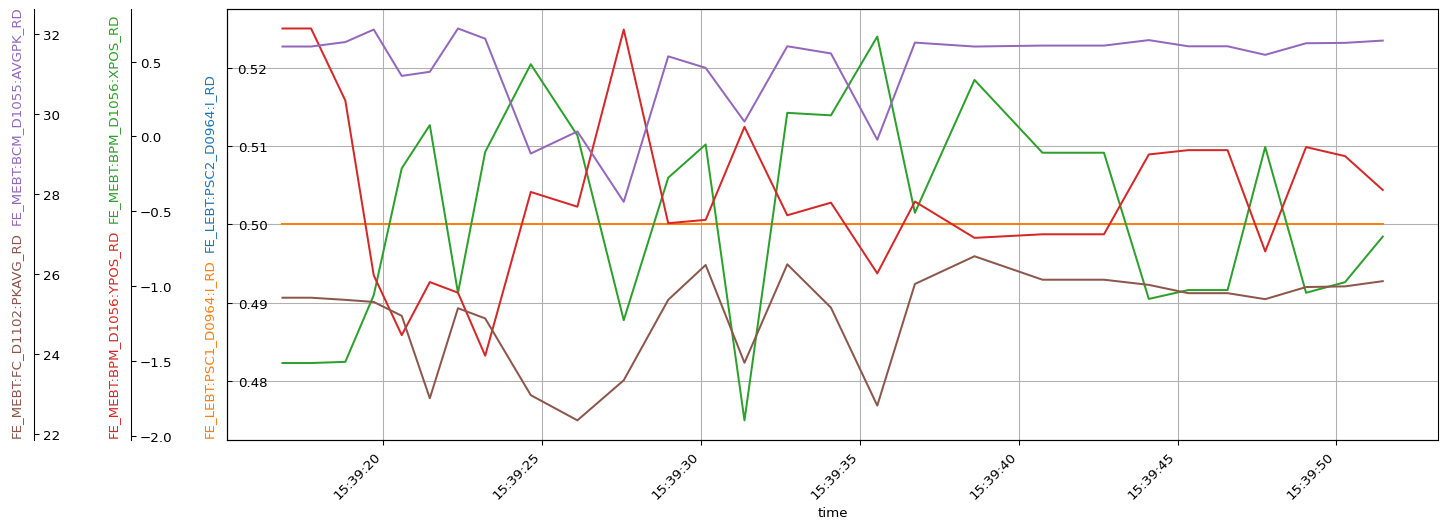

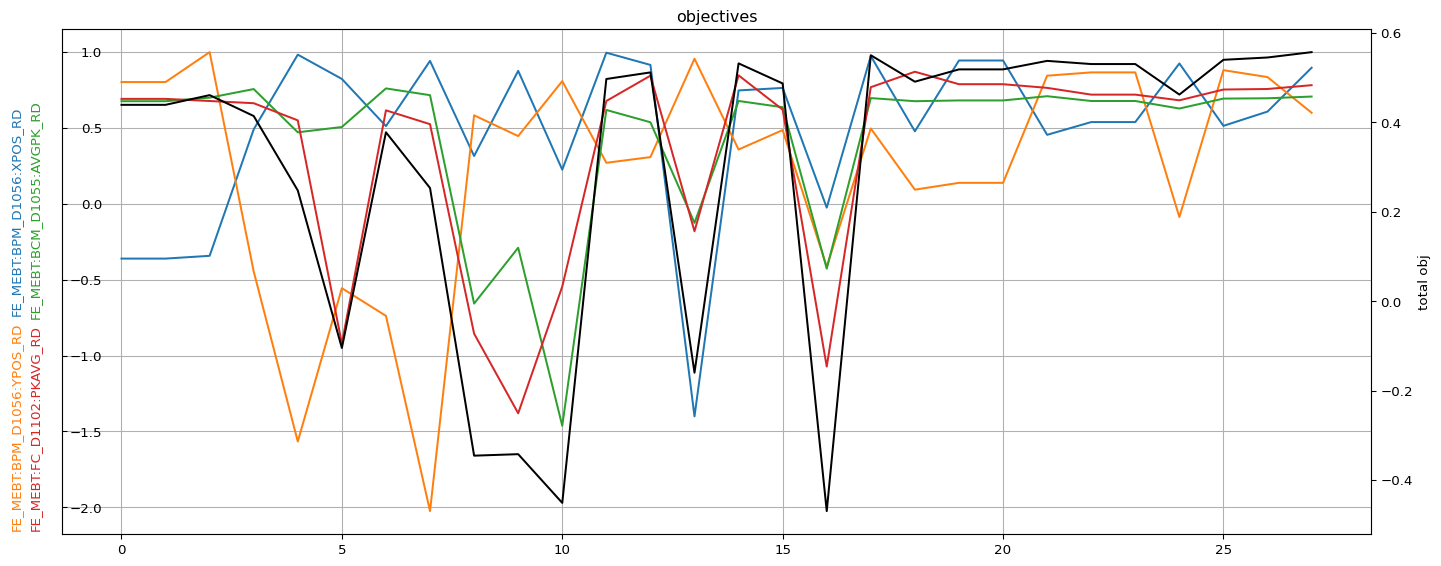

x data has duplicates. will remove duplicates and will average corresponding ys
[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



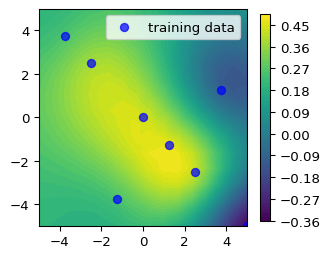

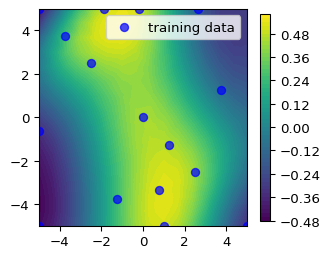

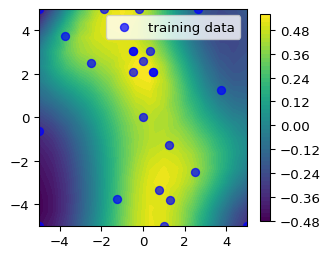

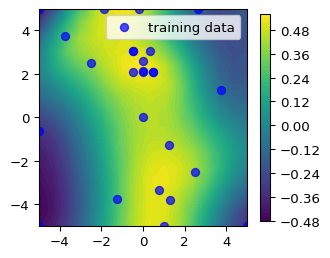

In [21]:
# optimize
ctrBO.init(n_init_budget)  
ctrBO.bo.plot_model_2D_projection(project_maximum=True,
                            dim_xaxis = 0,
                            dim_yaxis = 1,
                            grid_ponits_each_dim = 16,
                            );
ctrBO.optimize_global(n_global_opt_budget, beta_scheduler='auto')
ctrBO.bo.plot_model_2D_projection(project_maximum=True,
                            dim_xaxis = 0,
                            dim_yaxis = 1,
                            grid_ponits_each_dim = 16,
                            );
ctrBO.optimize_local (n_local_opt_budget , beta_scheduler='auto')
ctrBO.bo.plot_model_2D_projection(project_maximum=True,
                            dim_xaxis = 0,
                            dim_yaxis = 1,
                            grid_ponits_each_dim = 16,
                            );
ctrBO.fine_tune(n_finetune_budget)
ctrBO.bo.plot_model_2D_projection(project_maximum=True,
                            dim_xaxis = 0,
                            dim_yaxis = 1,
                            grid_ponits_each_dim = 16,
                            );
ctrBO.finalize()
for f in ctrBO.plot_callbacks:
    f.close()

### additional optimization as needed

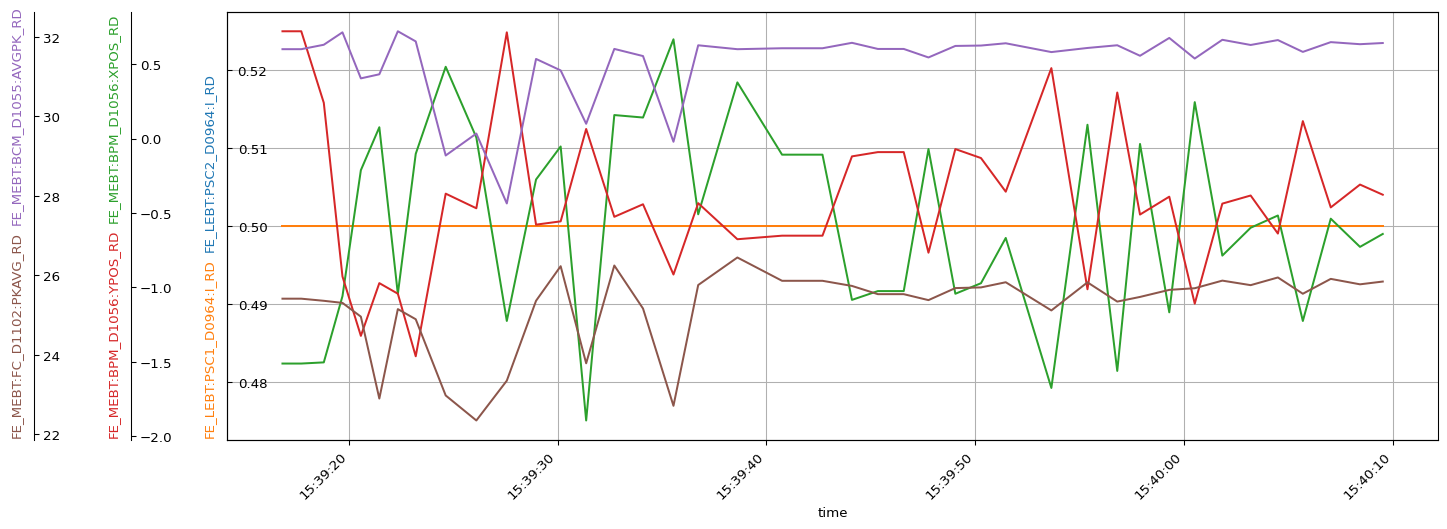

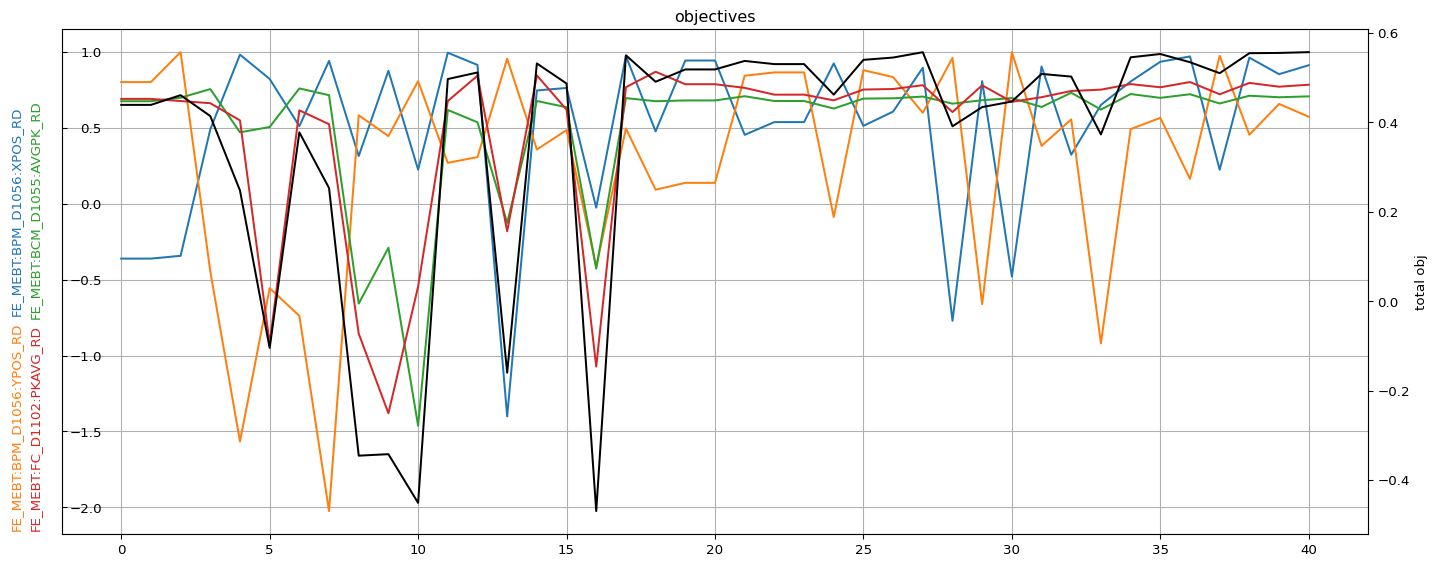

In [22]:
#== uncomment one (ore more) of the followings to optimize further
ctrBO.optimize_global(niter=10, beta_scheduler='auto')
ctrBO.optimize_local (niter=2, beta_scheduler='auto')

#== uncomment the followings too if any of above is uncommented
ctrBO.fine_tune(niter=1)
ctrBO.finalize()
for f in ctrBO.plot_callbacks:
    f.close()

### plot accumulated best objectives

<Axes: xlabel='evaluation budget', ylabel='best objective'>

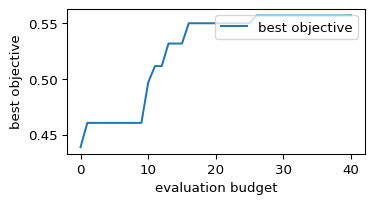

In [23]:
fig,ax = plt.subplots(figsize=(4,2),dpi=96)
ctrBO.bo.plot_obj_history(ax=ax, plot_best_only=True)

### set to best solution 

In [24]:
x_best,y_best_old = ctrBO.bo.best_sofar()
y_best_new = obj(x_best)
print(f'x_best: {x_best}')
print(f'y_best_old: {y_best_old[0]}')
print(f'y_best_new: {y_best_new}')   # check if best solution objective value is consistent

x_best: [-0.32516435  2.4912271 ]
y_best_old: 0.5567455076312796
y_best_new: 0.5567455076312796


In [25]:
# obj.save(fname=os.path.join('/files/shared/ap/jupyter-notebook/data/log/',fname))

# Visualize Surrogate model

[████████████████████████████████████████] 100%/100%



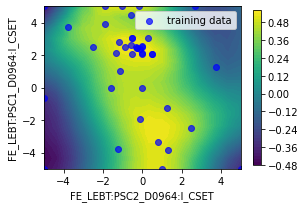

In [26]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4
bo = ctrBO.bo
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    grid_ponits_each_dim = 16,
                                    fig=fig,ax=ax_);
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()